# Pocket Dial vs. Regular Call Classification

My project for the Intro to Machine Learning class attempts to classify pocket dials vs. regular calls. The project idea was inspired by multiple reports about pocket dials wasting 911 operators' valuable time.

http://www.techtimes.com/articles/92149/20151007/911-calls-from-accidental-butt-dials-are-becoming-a-major-problem-for-emergency-services-google-report.htm

My approach is to teach a Convolutional Neural Network to distinguish between spectrograms obtained from pocket dial audio and speech audio files.

I started my research by looking into speech vs. music classification and genre classification using CNNs. 
Some of the articles I looked into were:

_Recognizing Sounds (A Deep Learning Case Study)_ <br>
https://medium.com/@awjuliani/recognizing-sounds-a-deep-learning-case-study-1bc37444d44d

_Finding the genre of a song with Deep Learning_ <br>
https://chatbotslife.com/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194

_Music-Speech Discrimination_ <br>
http://cs229.stanford.edu/proj2016/report/KaulMalviyaGoyal-MusicSpeechDiscrimination-report.pdf

I haven't found a single article that would talk about distinguishing between noise and speech or recognizing pocket dials.

#### Data
I used about more than 1000 speech and silence samples because I decided that silence should not be interpreted as a pocket dial. Speech samples contained both male and female voices. I used VoxForge (http://www.voxforge.org/) datasets at first. However, all of the speech samples I downloaded contained only male speech. I had to record female speech samples on my own and I used an audiobook "Little Women" (I thought it was a reasonable choice considering that most of the characters as well as the narrator were women). The pocket dial samples I recorded myself; I tried imitating pocket dial noises by tapping on the microphone etc. In total, the dataset consisted of 2600 5-second audio samples.
(I can provide .p files that contain the numpy arrays, if required.)

#### Results
My neural net reaches ~99% accuracy while training and 99.22% accuracy on the testing set. However, it sometimes makes unexplained mistakes when introducing it to entirely new test samples recorded during testing phase. For instance, it recognizes my speech as a regular call, but audio from a YouTube video gets classified as a pocket dial. Also, even though I introduced some recording of silence and labeled them as regular calls, the CNN still misclassifies them often.

#### Future work
First of all, I want to teach the CNN to classify silence with no background noise as a regular call. It also would be interesting to investigate why it misclassifies certain audio samples. So far, I wasn't able to find a distinct pattern. Also, a more robust system would be independent of the relative loudness of an audio sample which would require audio compression. My eventual goal would be to process audio in real time without creating spectrograms which could probably be achieved by using Recurrent Neural Nets and LSTM.

##### Filetree structure

    ├── README.md 
    ├── src
    │   └── Pocket_dial_vs_regular_call_CNN.ipynb
    │   └── my_cnn_model.h5
    │   └── test_X_main.p
    │   └── test_y_main.p
    │   └── train_X_main.p
    │   └── train_y_main.p
    │   └── validation_X_main.p
    │   └── validation_y_main.p
    ├── test_audio
    │   └── test_audio_0001.wav
    │   └── test_audio_0002.wav
    │   └── ...
    │   └── test_audio_2000.wav
    ├── test_spectrograms
    │   └── test_audio_0001_spec.png
    │   └── test_audio_0002_spec.png
    │   └── ...
    │   └── test_audio_2000_spec.png

## Part 1: Data Preprocessing

First we import all necessary packages:

In [1]:
import os # for reading files from the project directory

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# for recording sample audio for testing
import pyaudio # pip/pip3 install pyaudio
import wave

# for creating spectrograms
import librosa # pip/pip3 install librosa
import librosa.display
import librosa.feature

# for image processing
from PIL import Image
import PIL

# for data storage
import pickle
import h5py

Next, we define some functions that will be necessary for data processing.

In [2]:
# Image processing

#Returns numpy image at size imageSize*imageSize
def getProcessedData(img,imageSize, grayscale):
    numchannels = 4
    if grayscale:
        numchannels = 2            
    img = img.resize((imageSize,imageSize), resample=Image.ANTIALIAS)
    imgData = np.array(img, dtype=np.uint8).reshape(img.size[0], img.size[1], numchannels)


    imgData = imgData[:, :, :-1]
    imgData = imgData/255.
    return imgData

#Returns numpy image at size imageSize*imageSize
def getImageData(filename,imageSize, grayscale):
    if grayscale:
        img = Image.open(filename).convert('LA')
    else:
        img = Image.open(filename)
    imgData = getProcessedData(img, imageSize, grayscale)
    return imgData

Below, we define functions that create and save, or load our dataset.

In [3]:
from random import shuffle

directory = "../test_spectrograms/"

def createDataset(size, validationRatio, testRatio, grayscale):
    data = []
    numchannels = 3
    if grayscale:
        numchannels = 1
    count = 1
    #Add data (X,y)
    for filename in os.listdir(directory):
        if filename[:1] != '.':
            path = os.path.join(directory, filename)
            imgData = getImageData(path, size, grayscale)
            label = 1.
            
            # these filenames are specific to my data
            if filename[:4] == "nois" or filename[:4] == "audi" or filename[:4] == "myno":
                label = 0.
            data.append((imgData,label))

    #Shuffle data
    shuffle(data)

    #Extract X and y
    X,y = zip(*data)

    #Split data
    validationNb = int(len(X)*validationRatio)
    testNb = int(len(X)*testRatio)
    trainNb = len(X)-(validationNb + testNb)

    train_X = np.array(X[:trainNb]).reshape([-1, size, size, 1])
    train_y = np.array(y[:trainNb])
    validation_X = np.array(X[trainNb:trainNb+validationNb]).reshape([-1, size, size, 1])
    validation_y = np.array(y[trainNb:trainNb+validationNb])
    test_X = np.array(X[-testNb:]).reshape([-1, size, size, 1])
    test_y = np.array(y[-testNb:])
    
    train_y = np.reshape(train_y, (-1, 1))
    test_y = np.reshape(test_y, (-1, 1))
    validation_y = np.reshape(validation_y, (-1, 1))
    
    print("Dataset created!")

    return train_X, train_y, validation_X, validation_y, test_X, test_y


def saveDataset(train_X, train_y, validation_X, validation_y, test_X, test_y):

    print("Saving dataset... ")
    datasetName = "main"
    pickle.dump(train_X, open("train_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(train_y, open("train_y_{}.p".format(datasetName), "wb" ))
    pickle.dump(validation_X, open("validation_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(validation_y, open("validation_y_{}.p".format(datasetName), "wb" ))
    pickle.dump(test_X, open("test_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(test_y, open("test_y_{}.p".format(datasetName), "wb" ))
    print("Dataset saved!")
    
def loadDataset():
    
    datasetName = "main"
    print("Loading training and validation datasets... ")
    train_X = pickle.load(open("train_X_{}.p".format(datasetName), "rb" ))
    train_y = pickle.load(open("train_y_{}.p".format(datasetName), "rb" ))
    validation_X = pickle.load(open("validation_X_{}.p".format(datasetName), "rb" ))
    validation_y = pickle.load(open("validation_y_{}.p".format(datasetName), "rb" ))
    print("Training and validation datasets loaded!")
    print("Loading testing dataset... ")
    test_X = pickle.load(open("test_X_{}.p".format(datasetName), "rb" ))
    test_y = pickle.load(open("test_y_{}.p".format(datasetName), "rb" ))
    print("Testing dataset loaded!")
    
    return train_X, train_y, validation_X, validation_y, test_X, test_y

Next, you have a choice of retraining the network, or using the model I trained on my dataset.

In [4]:
input_valid = False
while not input_valid:
    train_or_test = input("Would you like to train or test the network? Type 'train' or 'test': ")
    train_or_test = train_or_test.lower()

    if train_or_test != 'train' and train_or_test != 'test':
        print("Please, type 'train' or 'test'")
    else:
        input_valid = True 

Would you like to train or test the network? Type 'train' or 'test': test


Depending on your choice above, you will either load data or create new dataset.

In [5]:
if train_or_test == "train":
    
    image_size = 128
    validation_ratio = 0.3
    test_ratio = 0.1
    grayscale = True
    
    # Convert audio files to spectrograms:

    directory = "../test_audio/"

    plt.figure(figsize=(12, 12))
    for filename in os.listdir(directory):
        if filename[:1] != ".":
            path = os.path.join(directory, filename)

            y, sr = librosa.load(path)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
            librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                                    fmax=4000)
            output_filename = "../test_spectrograms/" + filename[:-4] + "_spec" + IMG_EXT
            plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
    
    train_X, train_y, validation_X, validation_y, test_X, test_y = createDataset(image_size, 
                                                                                 validation_ratio, 
                                                                                 test_ratio, 
                                                                                 grayscale)
    saveDataset(train_X, train_y, validation_X, validation_y, test_X, test_y)
    
elif train_or_test == "test":
    
    train_X, train_y, validation_X, validation_y, test_X, test_y = loadDataset()

Loading training and validation datasets... 
Training and validation datasets loaded!
Loading testing dataset... 
Testing dataset loaded!


Next, we normalize the data by subtracting the mean and dividing by the standard deviation of the training dataset.

In [6]:
xstd = np.std(train_X)
xmean = np.mean(train_X)
Xtr = (train_X - xmean) / xstd
Xts = (test_X - xmean) / xstd
Xval = (validation_X - xmean) / xstd

## Part 2: Training or Testing the Convolutional Neural Net Model

First, we import the keras packages and clear session.

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
import keras.backend as K
K.clear_session()

Below is the CNN model summary and definition.

My model uses 2 convolutional layers followed by MaxPool layers.

In [9]:
input_shape = Xtr.shape[1:]

model = Sequential()
model.add(Conv2D(input_shape=input_shape, 
                kernel_size=(16,16),
                filters=8,activation="elu"))
model.add(MaxPooling2D(pool_size=(16,16)))

model.add(Conv2D(128,kernel_size=(4,4),  activation="elu"))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(128, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 113, 8)       2056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         16512     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

The simple optimizer below is sufficient for this network.

In [10]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

If we are in the training mode, we train the CNN for 10 epochs.

In [11]:
if train_or_test == 'train':
    model.fit(Xtr, train_y, epochs=10, validation_data=(Xval, validation_y))
    model.save('my_cnn_model.h5')  # creates a HDF5 file 'my_model.h5'

If we are in the testing mode, we load the existing model from the current working directory.
We print model summary to make sure this is the right model.

In [12]:
# requires h5py: use pip/pip3 install h5py
from keras.models import load_model

if train_or_test == 'test':
    model = load_model('my_cnn_model.h5')
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 113, 8)       2056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         16512     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

We test the model using 10% of our dataset:

In [13]:
score, acc = model.evaluate(Xts, test_y)
print("Accuracy is {}%".format(round(acc*100, 2)))

258/258 [==============================] - 3s 13ms/step
Accuracy is 99.22%


Next, we test the model by recording a test audio. We also save the spectrogram.

Test by recording sound [y/n]: y
recording...
finished recording

Saved spectrogram:


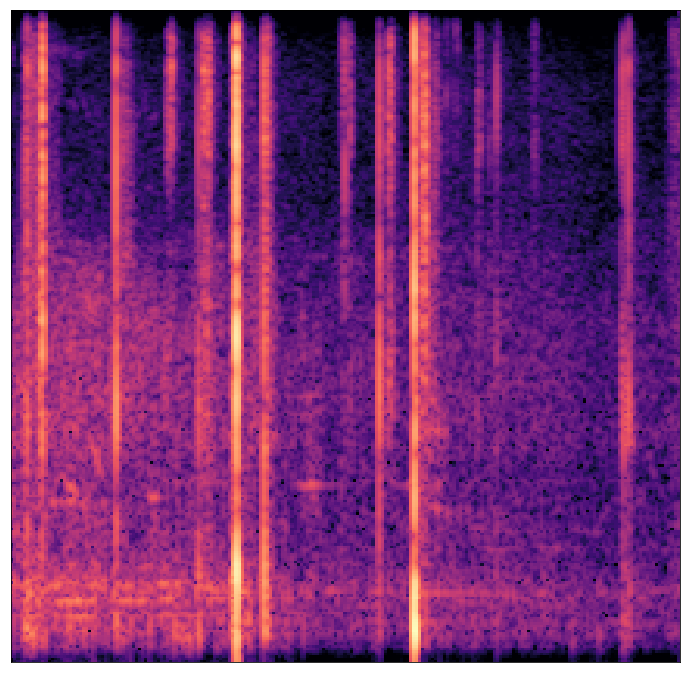

In [17]:
do_rec = input("Test by recording sound [y/n]: ")

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 8000 # low rate so that the audio resembles phone call quality
CHUNK = 1024
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "test_audio.wav"
IMG_EXT = ".png"

if do_rec.lower() == 'y':
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print ("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print ("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
    
    plt.figure(figsize=(12, 12))
    y, sr = librosa.load(WAVE_OUTPUT_FILENAME)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
    librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                            fmax=4000)
    output_filename = WAVE_OUTPUT_FILENAME[:-4] + "_spec" + IMG_EXT
    plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
    print("\nSaved spectrogram:")

The spectrogram below gives us more information about the recorded file.

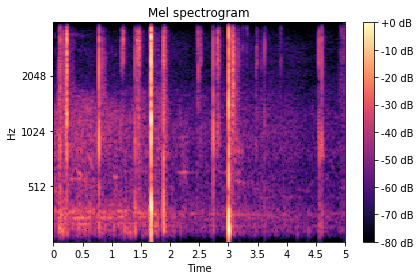

In [18]:
y, sr = librosa.load(WAVE_OUTPUT_FILENAME)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                        fmax=4000)
output_filename = WAVE_OUTPUT_FILENAME[:-4] + "_spec" + IMG_EXT
#     plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                         y_axis='mel', fmax=4000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

### Prediction time!

In [19]:
path = "./test_audio_spec.png"
image_size = 128
validation_ratio = 0.3
test_ratio = 0.1
grayscale = True

# get image data and convert to a numpy array
imgData = getImageData(path, image_size, grayscale)
X_predict = imgData
X_predict = np.array(X_predict).reshape([-1, 128, 128, 1])

# normalize
X_predict = (X_predict - xmean) / xstd

prediction = model.predict(X_predict)[0][0]
if prediction > 0.1:
    print(">>>> Regular call! ✅  Probability: {0}".format(prediction))
else:
    print(">>>> Pocket dial! ❌  Probability: {0}".format(prediction))


>>>> Pocket dial! ❌  Probability: 0.0038375824224203825
